# 读取数据，去重

In [45]:
import pandas as pd
import os
city = '北京'

dfs = []
for root, dirs, files in os.walk('chengjiao-%s'%city):
    #print(root, files, dirs)
    files.sort()
    for f in files:
        print(root, f)
        if f.endswith('.xls'):
            dfs.append(pd.read_excel(os.path.join(root, f), converters = {'成交价(元/平)':lambda x:float(x),
                                                                          '链家编号':str}))
        if f.endswith('.csv'):
            dfs.append(pd.read_csv(os.path.join(root, f), converters = {'成交价(元/平)':lambda x:float(x),
                                                                        '链家编号':str}))
df = pd.concat(dfs)
df = df.drop_duplicates(subset=['链家编号'])
df = df.loc[df['成交价(元/平)']> 1000]
len(df)

chengjiao-北京 北京.csv


17420

In [44]:
df.to_csv('%s.csv'%city, index=False)

20231

# 计算全市日均价与成交量序列

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


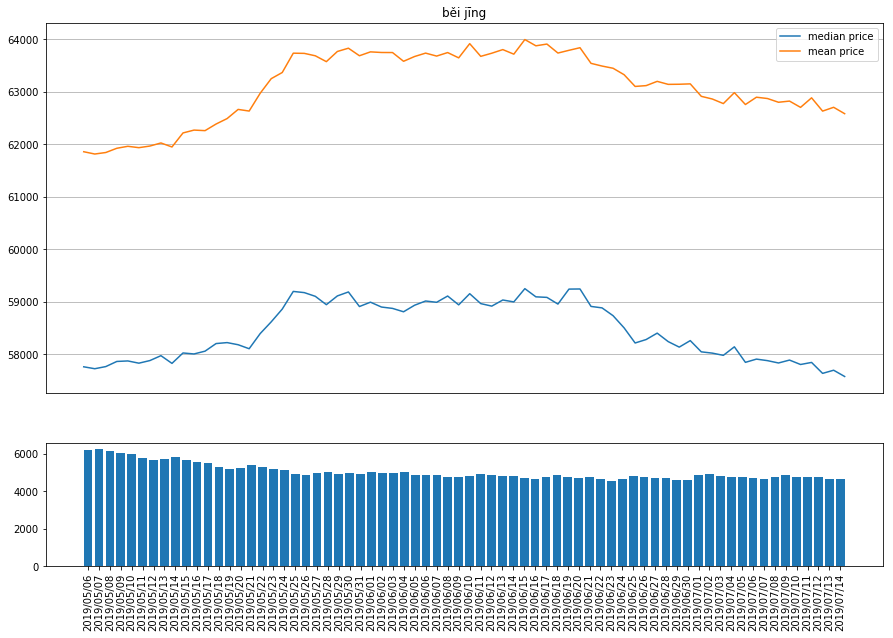

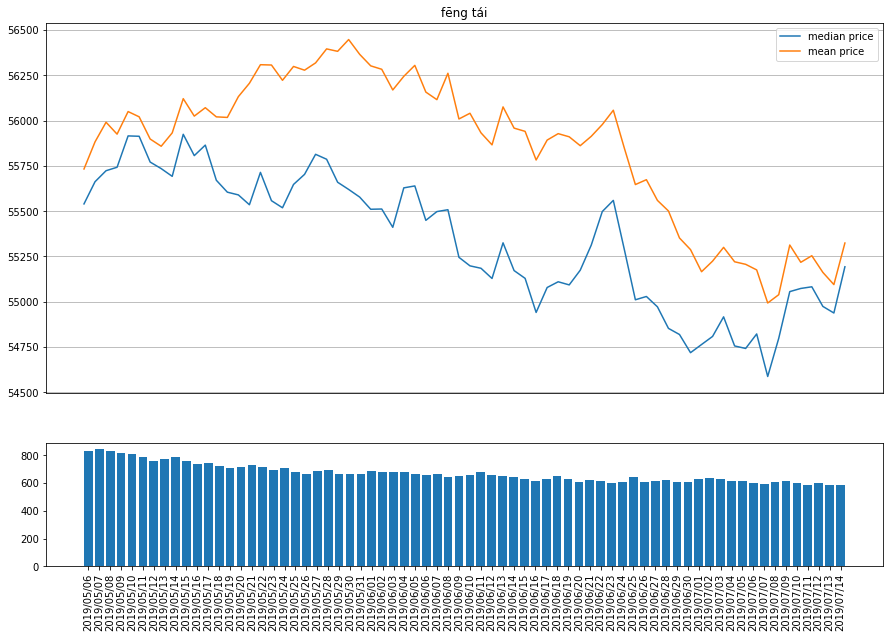

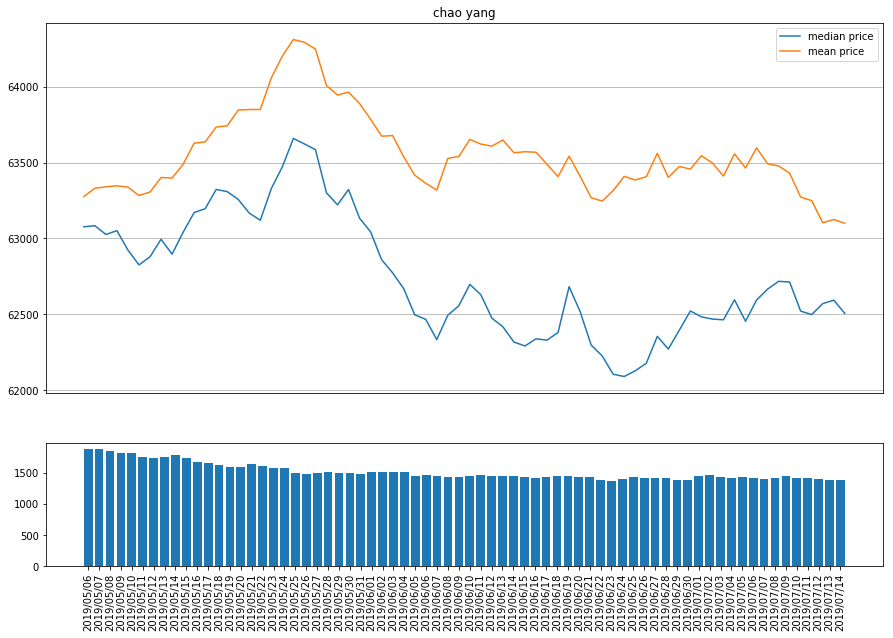

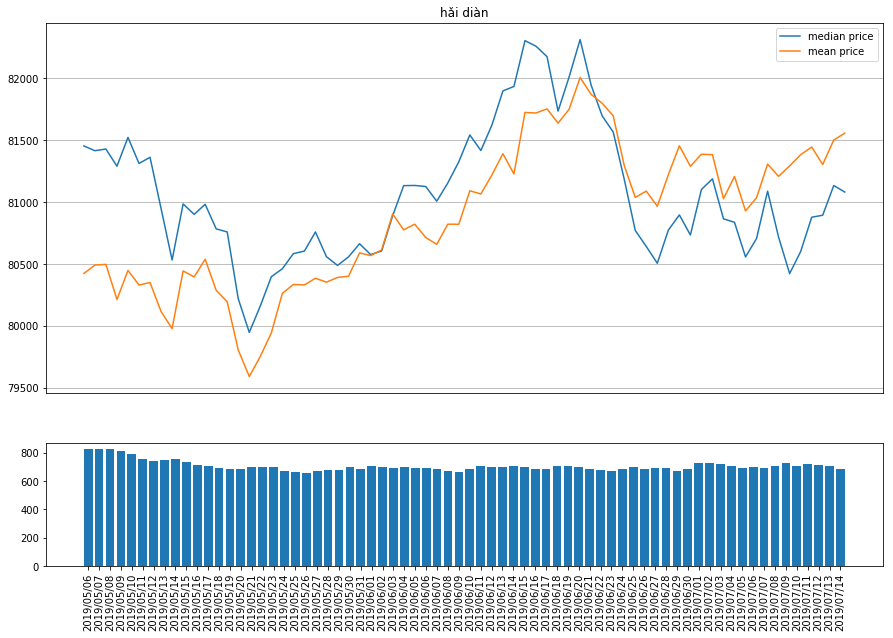

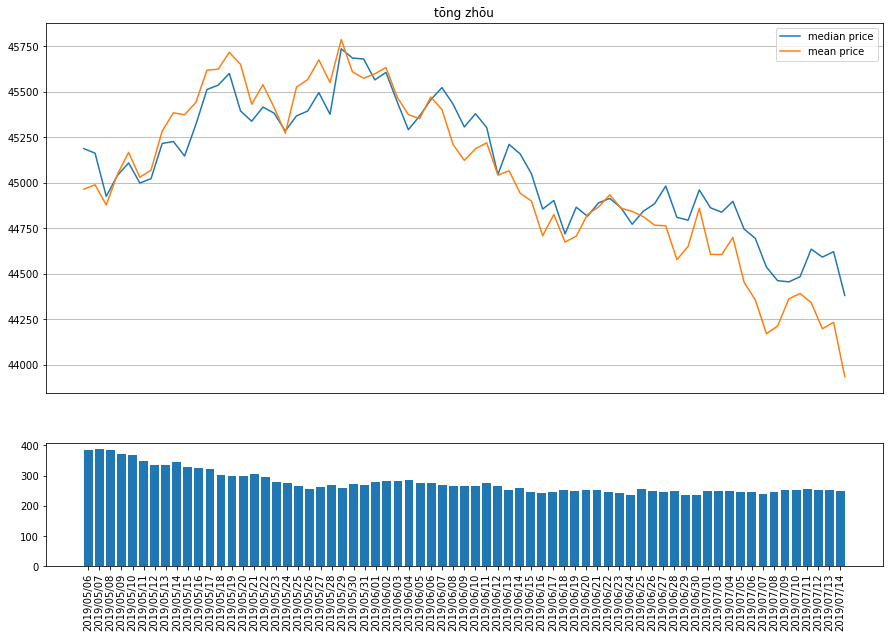

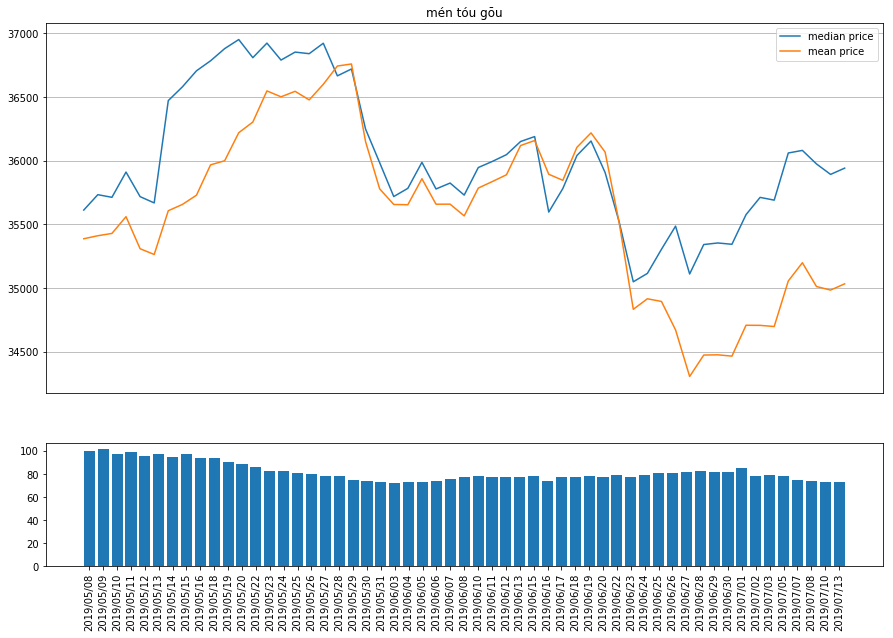

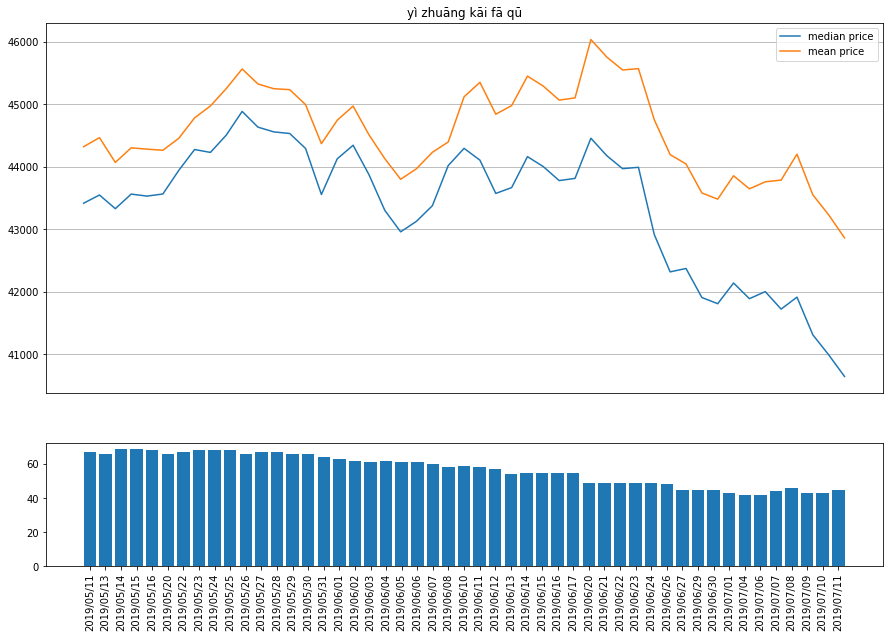

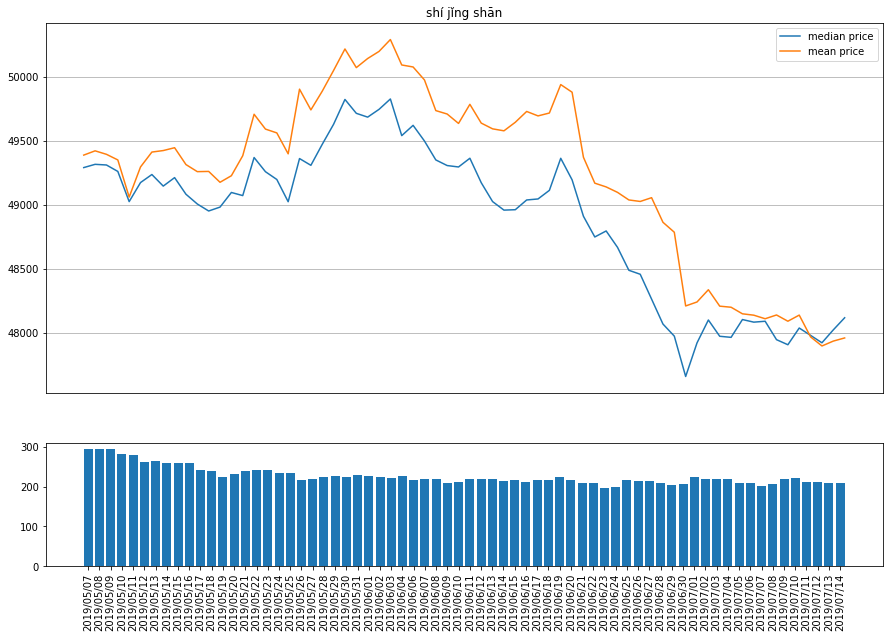

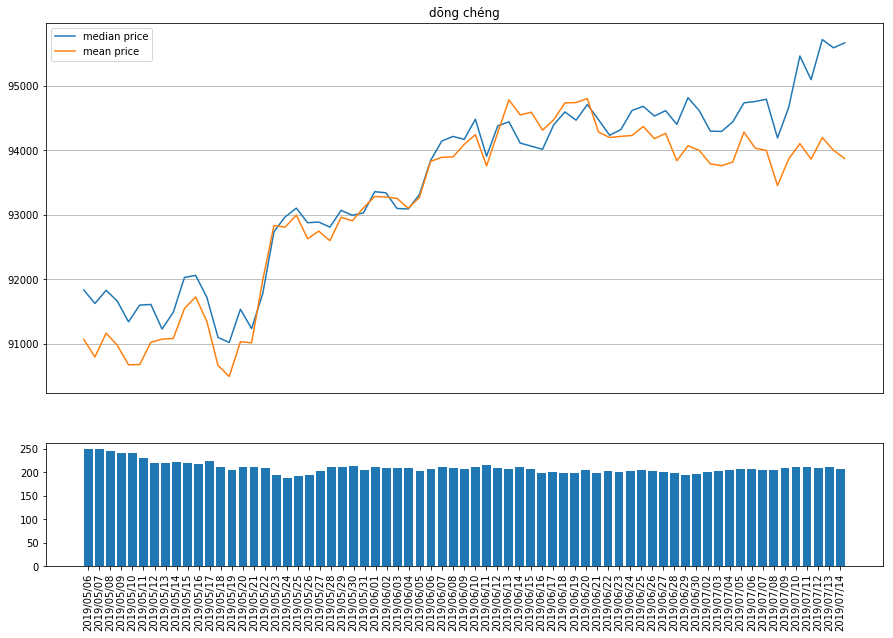

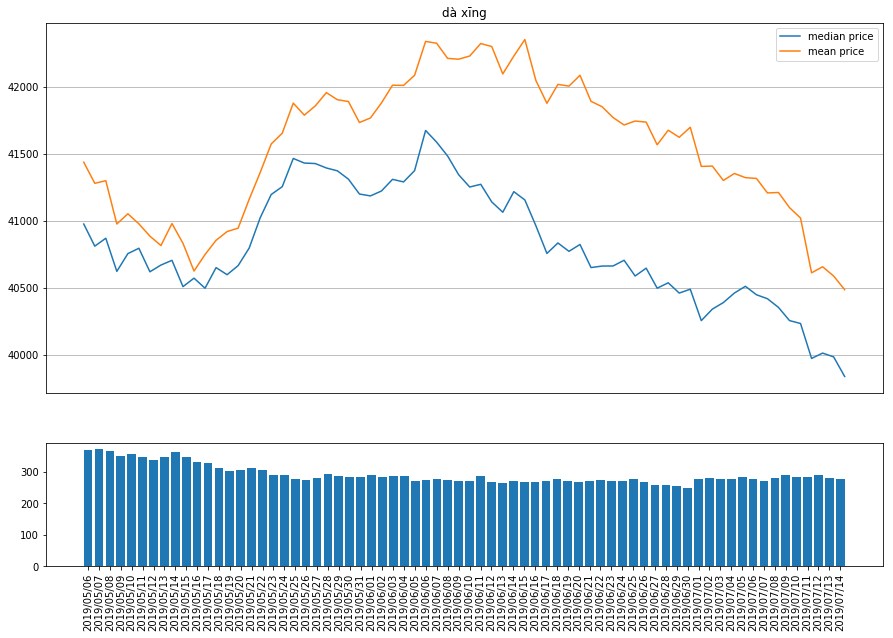

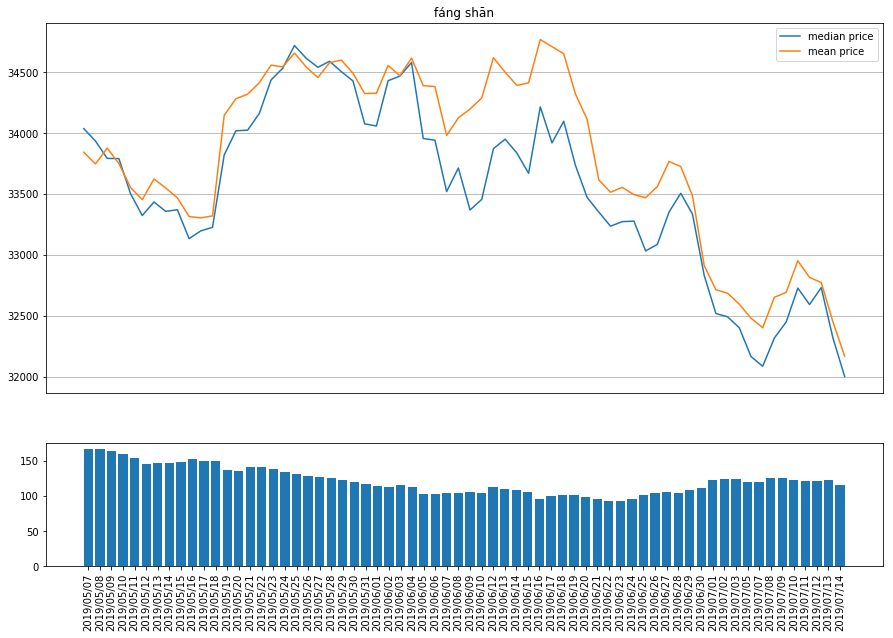

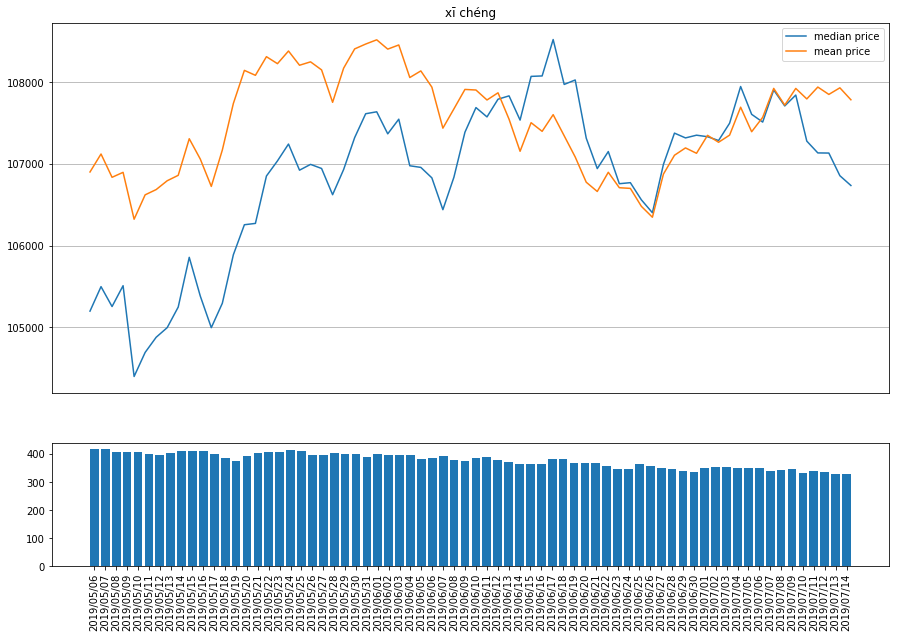

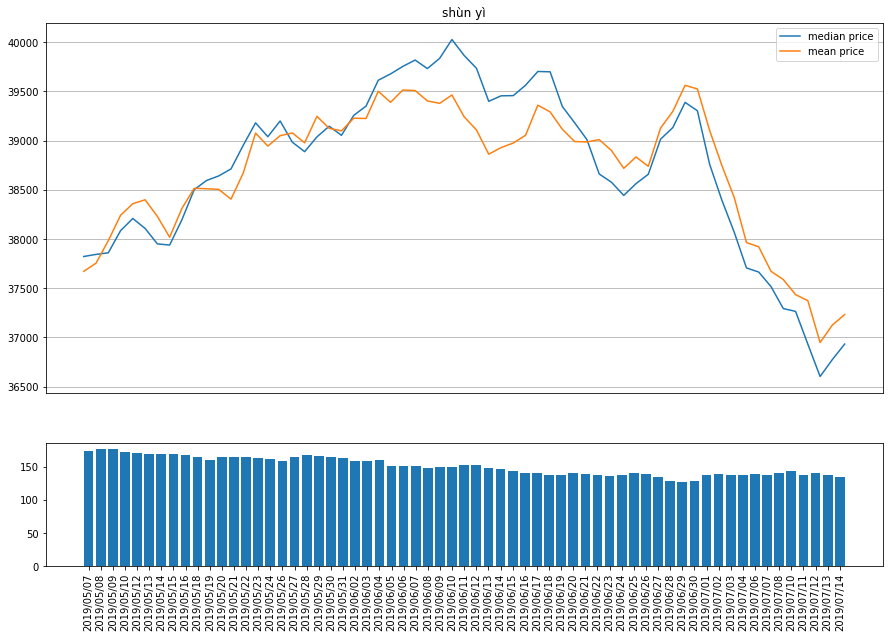

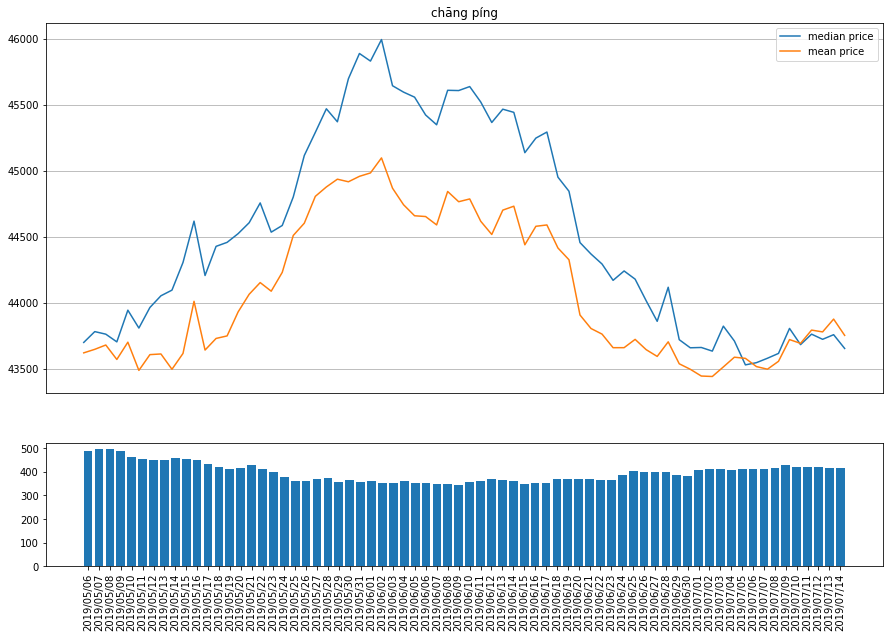

In [48]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import gridspec
from pypinyin import pinyin
import numpy as np
MA = True
#MA = False
ma_length = 30
def get_moving_average(res, ma_length):
    volume_ma = []
    median_ma = []
    mean_ma = []
    for i in range(len(res) - ma_length):
        volume_ele = sum(res['volume'].iloc[i:i+ma_length])
        median_ele = 0
        mean_ele = 0
        for j in range(i, i + ma_length):
            median_ele += res['volume'].iloc[j] * res['median_price'].iloc[j]
            mean_ele += res['volume'].iloc[j] * res['mean_price'].iloc[j]
        volume_ma.append(volume_ele)    
        median_ma.append(median_ele/volume_ele)
        mean_ma.append(mean_ele/volume_ele)
    return pd.DataFrame({'volume':volume_ma, 'median_price':median_ma,  'mean_price':mean_ma}, 
                        index = res.index[ma_length:])

def plot(res, title, MA, ma_length):
    if  len(res)< 10:
        return
    if MA == True:
        res = get_moving_average(res, ma_length)
    plt.rcParams['font.sans-serif']=['SimHei']
    matplotlib.rcParams['figure.figsize'] = [15, 10]
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    ax0 = plt.subplot(gs[0])
    ax0.plot(res['median_price'])
    ax0.plot(res['mean_price'])
    ax0.legend(['median price','mean price'])
    plt.xticks([])
    plt.title(title)
    plt.grid('on')
    ax1 = plt.subplot(gs[1])
    ax1.bar(res.index, res['volume'])
    plt.xticks(rotation=90)
    dir_name = os.path.join('fig', city)
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    plt.savefig(os.path.join(dir_name, title +'.png'))
    plt.show()
    plt.close()


gp = df.groupby(['成交时间'])['成交价(元/平)']
res=pd.DataFrame({"volume":gp.size(),"median_price":gp.median(), "mean_price":gp.mean()})
res = res.iloc[:len(res)-1,:]
title = pinyin(city)
title = " ".join([x[0] for x in title])
plot(res, title, MA, ma_length)
                        
def plot_district(district ='朝阳'):
    gp = df.loc[df['下辖区']==district].groupby(['成交时间'])
    res = pd.DataFrame({'volume':gp.size(),'mean_price':gp['成交价(元/平)'].mean(), 'median_price':gp['成交价(元/平)'].median()})
    res = res.iloc[:len(res) -1,:]
    
    title = pinyin(district)
    if district == '朝阳':
        title = 'chao yang'
    elif district == '长宁':
        title = 'chang ning'
    elif district == '闵行':
        title = 'min hang'
    else:
        title = " ".join([x[0] for x in title])
    plot(res, title, MA, ma_length)
districts = list(set(df['下辖区']))
for district in districts:
    plot_district(district)


In [12]:
pd.options.display.max_columns = None
#df.loc[df['小区'].str.contains('团结湖南里')]
df.loc[df['小区'].str.contains('爱乐')].sort_values(by='成交时间', ascending=False)
#df.loc[df['小区'].str.contains('平乐园')].sort_values(by='成交时间', ascending=False)

,链家编号,建筑面积,朝向,户型,成交价(元/平),城市,下辖区,商圈,小区,成交时间,关注(人),带看(次),浏览(次),成交周期(天),挂牌价格(万),售价(万),调价(次),建成时间,户型结构,套内面积,电梯,梯户比例,供暖方式,装修,楼型,楼层状态,房屋年限,房屋用途,交易权属,产权所属,土地年限,标题,来源
260,101104826399,67.26,东,1室1厅1卫,58727,北京,朝阳,常营,柏林爱乐二期,2019/07/12,79,40,6689,44,406.0,395.0,1,200.0,平层,54.06㎡,有,一梯三户,集中供暖,精装,板楼,高楼层/11层,满五年,普通住宅,商品房,非共有,详见业主土地证明材料或相关政府部门登记文件,柏林爱乐二期 1室1厅 67.26㎡,NaN
234,101104938603,60.57,西南,1室0厅1卫,53162,北京,朝阳,常营,柏林爱乐二期,2019/07/07,12,15,366,25,335.0,322.0,1,200.0,平层,47.4㎡,有,两梯十户,集中供暖,精装,塔楼,高楼层/24层,满两年,普通住宅,商品房,非共有,详见业主土地证明材料或相关政府部门登记文件,柏林爱乐二期 1室--厅 60.57㎡,NaN
583,101105060082,103.82,南 北,2室1厅2卫,58659,北京,朝阳,常营,柏林爱乐二期,2019/07/05,18,10,313,7,615.0,609.0,0,200.0,平层,88.27㎡,有,一梯两户,集中供暖,其他,板楼,中楼层/8层,满两年,普通住宅,商品房,非共有,详见业主土地证明材料或相关政府部门登记文件,柏林爱乐二期 2室1厅 103.82㎡,NaN
712,101104569295,72.19,东 西,2室1厅1卫,53331,北京,朝阳,常营,柏林爱乐三期,2019/06/30,34,64,1144,68,410.0,385.0,0,200.0,平层,56.98㎡,有,一梯两户,集中供暖,精装,板楼,高楼层/11层,满五年,普通住宅,商品房,非共有,详见业主土地证明材料或相关政府部门登记文件,柏林爱乐三期 2室1厅 72.19㎡,NaN
565,101104130966,57.89,西北,1室1厅1卫,56486,北京,朝阳,常营,柏林爱乐二期,2019/06/25,167,54,3530,122,345.0,327.0,0,200.0,平层,45.51㎡,有,两梯十户,集中供暖,精装,塔楼,高楼层/21层,满五年,普通住宅,商品房,非共有,详见业主土地证明材料或相关政府部门登记文件,柏林爱乐二期 1室1厅 57.89㎡,NaN
1260,101104343078,58.93,东北,1室0厅1卫,52265,北京,朝阳,常营,柏林爱乐二期,2019/06/22,44,70,1750,90,318.0,308.0,1,200.0,平层,45.94㎡,有,两梯十户,集中供暖,简装,塔楼,高楼层/22层,满两年,普通住宅,商品房,非共有,详见业主土地证明材料或相关政府部门登记文件,柏林爱乐二期 1室--厅 58.93㎡,NaN
233,101104569319,68.59,南,1室1厅1卫,57589,北京,朝阳,常营,柏林爱乐三期,2019/06/14,60,86,2795,52,410.0,395.0,1,200.0,平层,52.56㎡,有,两梯三户,集中供暖,简装,板楼,中楼层/15层,满五年,普通住宅,私产,共有,详见业主土地证明材料或相关政府部门登记文件,柏林爱乐三期 1室1厅 68.59㎡,NaN
908,101104569319,68.59,南,1室1厅1卫,57589,北京,朝阳,常营,柏林爱乐三期,2019/06/14,60,86,2811,52,410.0,395.0,1,200.0,平层,52.56㎡,有,两梯三户,集中供暖,简装,板楼,中楼层/15层,满五年,普通住宅,私产,共有,详见业主土地证明材料或相关政府部门登记文件,柏林爱乐三期 1室1厅 68.59㎡,NaN
1346,101104737050,101.23,南 北,2室1厅2卫,60259,北京,朝阳,常营,柏林爱乐二期,2019/06/11,22,11,460,26,628.0,610.0,1,200.0,平层,86.07㎡,有,一梯两户,集中供暖,简装,板楼,底层/8层,满五年,普通住宅,商品房,非共有,详见业主土地证明材料或相关政府部门登记文件,柏林爱乐二期 2室1厅 101.23㎡,NaN
672,101104737050,101.23,南 北,2室1厅2卫,60259,北京,朝阳,常营,柏林爱乐二期,2019/06/11,22,11,452,26,628.0,610.0,1,200.0,平层,86.07㎡,有,一梯两户,集中供暖,简装,板楼,底层/8层,满五年,普通住宅,商品房,非共有,详见业主土地证明材料或相关政府部门登记文件,柏林爱乐二期 2室1厅 101.23㎡,NaN


In [13]:
x=df.groupby('小区')
x_mean  = x.mean()
x_size = x.size()
#x_size
x_mean=x_mean.loc[x_size>=1]
x_mean.sort_values(by='成交价(元/平)', ascending=False)

KeyError: '成交价(元/平)'

In [14]:
df.sort_values('售价(万)', ascending=False).loc[:,["小区", "建筑面积","成交价(元/平)", "售价(万)"]]

,小区,建筑面积,成交价(元/平),售价(万)
371,锦绣江南三期(别墅),568.64,59968,3410
958,湖畔佳苑(别墅),479.34,65006,3116
416,泰晤士小镇(别墅),565.40,48815,2760
1359,中建大公馆,595.55,46092,2745
239,白金湾府邸,278.28,89838,2500
355,国际丽都城,200.07,117959,2360
209,大华西郊别墅,394.52,58045,2290
1649,棕榈泉花园,370.17,59297,2195
2732,万源城御璄,262.80,83333,2190
147,百汇园,188.81,113765,2148


In [101]:
ma_length = 10
mean_price = df['成交价(元/平)'].mean()
price_std = df['成交价(元/平)'].std()
print('mean:', mean_price, 'std:', price_std)
threshold = 1.3
#high_df = df.loc[df['成交价(元/平)']>= mean_price + threshold * price_std]
#low_df =  df.loc[df['成交价(元/平)']< mean_price - threshold* price_std]
#medium_df = df.loc[df['成交价(元/平)']< mean_price + threshold * price_std]
#medium_df = medium_df.loc[medium_df['成交价(元/平)']>= mean_price - threshold * price_std]
df = df.sort_values('售价(万)')

high_df = df.iloc[:2000]
low_df = df.iloc[-2000:]
medium_df = df.iloc[2000:-2000]
print(len(high_df), len(low_df), len(medium_df))
def getPriceSeries(df):
    gp = df.groupby(['成交时间'])['成交价(元/平)']
    res=pd.DataFrame({"volume":gp.size(),"median_price":gp.median(), "mean_price":gp.mean()})
    res = res.sort_index()
    res = res.iloc[:len(res)-1]
    res = get_moving_average(res, ma_length)
    return res
highSeries=getPriceSeries(high_df)
mediumSeries=getPriceSeries(medium_df)
lowSeries=getPriceSeries(low_df)


mean: 62865.600765501404 std: 23833.699264310853
2000 2000 15595


/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


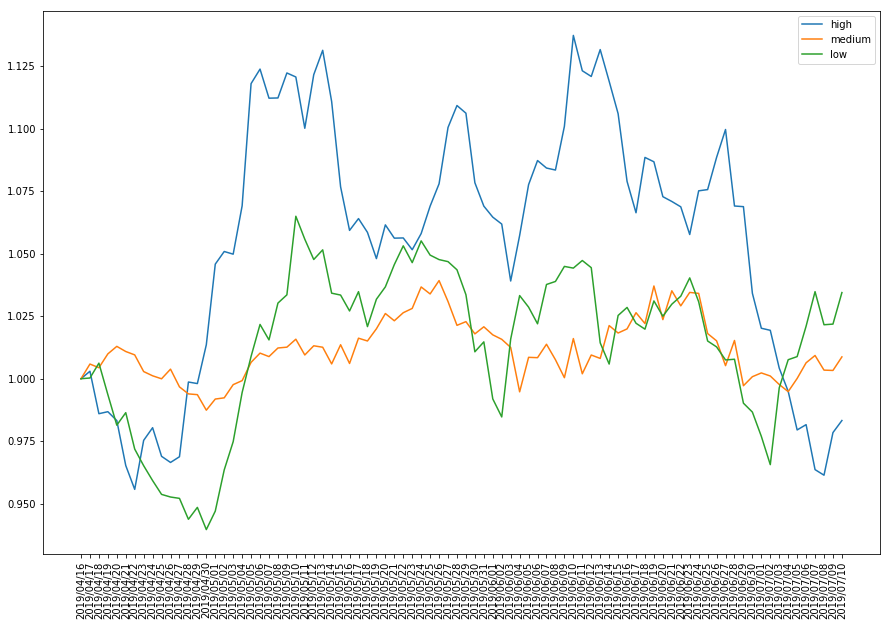

In [102]:
plt.plot(highSeries['mean_price']/highSeries['mean_price'][0])
plt.plot(mediumSeries['mean_price']/mediumSeries['mean_price'][0])
plt.plot(lowSeries['mean_price']/lowSeries['mean_price'][0])
plt.xticks(rotation=90)
plt.legend(['high','medium', 'low'])

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


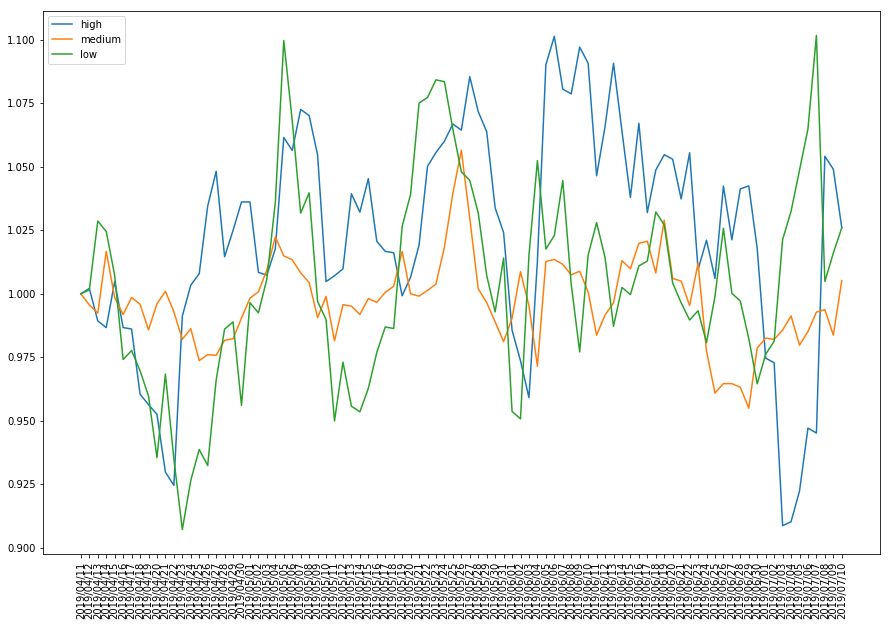

In [72]:
plt.plot(highSeries['median_price']/highSeries['median_price'][0])
plt.plot(mediumSeries['median_price']/mediumSeries['median_price'][0])
plt.plot(lowSeries['median_price']/lowSeries['median_price'][0])
plt.xticks(rotation=90)
plt.legend(['high','medium', 'low'])


/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


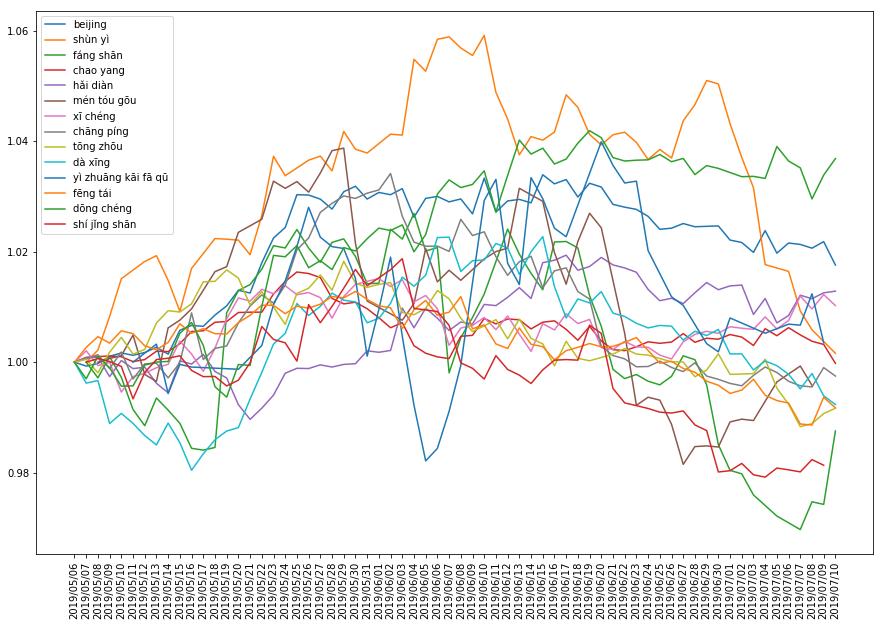

In [98]:
def plotAllDistrict(df, ma_length = 10):
    districts = list(set(df['下辖区']))
    legend = ['beijing']
    data = []
    gp = df.groupby(['成交时间'])['成交价(元/平)']
    res=pd.DataFrame({"volume":gp.size(),"median_price":gp.median(), "mean_price":gp.mean()})
    res = res.iloc[:len(res)-1,:]
    res = get_moving_average(res, ma_length)

    data.append(res)
    for district in districts:
        gp = df.loc[df['下辖区']==district].groupby(['成交时间'])
        res = pd.DataFrame({'volume':gp.size(),'mean_price':gp['成交价(元/平)'].mean(), 'median_price':gp['成交价(元/平)'].median()})
        res = res.iloc[:len(res) -1,:]
        res = get_moving_average(res, ma_length)
        if len(res) < 1:
            continue
        data.append(res)
        title = pinyin(district)
        if district == '朝阳':
            title = 'chao yang'
        elif district == '长宁':
            title = 'chang ning'
        elif district == '闵行':
            title = 'min hang'
        else:
            title = " ".join([x[0] for x in title])
        legend.append(title)
   
    for i in range(len(data)):
        plt.plot(data[i]['mean_price']/data[i]['mean_price'].iloc[0])
    plt.xticks(rotation=90)
    plt.legend(legend)
plotAllDistrict(df, 30)
    

In [113]:
df1 = df.loc[df['售价(万)']>=400]
df2 = df1.loc[df1['售价(万)']<=500]
df2.to_csv('400-500.csv', index=False, encoding ='gbk')